In [1]:
import os
import math
import scipy
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
from scipy import interpolate
from scipy.interpolate import Rbf
import seawater as sw
from seawater.library import T90conv
import warnings
warnings.filterwarnings("ignore")
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from numpy import save
from numpy import load
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras import regularizers  # 正则化

In [2]:
#xarray读取文件
xr_SSS = xr.open_dataset('数据/NASA-SSS.nc')  #'SSS'  12-21
xr_SST = xr.open_dataset('数据/NOAA-SST.nc')  #'SST'  00-20
xr_PRE = xr.open_dataset('数据/NOAA-precipitation 00-21.nc') #'GPI'  00-20

In [3]:
xr_PRE_month = xr_PRE['GPI'].resample(TIME="1MS").mean()

In [4]:
xr_SST_month = xr_SST['SST'][:-1,:,:].resample(TIME="1MS").mean()

In [5]:
year=['y2012','y2013','y2014','y2015','y2016','y2017','y2018','y2019','y2020']
month=['m01','m02','m03','m04','m05','m06','m07','m08','m09','m10','m11','m12']

b=np.zeros((1,xr_SSS['SSS'][:,:,30*4:120*4].shape[1],xr_SSS['SSS'][:,:,30*4:120*4].shape[2]))
for i in year:
    for j in month:
        locals()['xr_SSHA_'+i+'_'+j] = xr.open_dataset('数据/dt_global_allsat_msla_h_'+i+'_'+j+'.nc')  #'sla'
        xr_SSHA_i_j = locals()['xr_SSHA_'+i+'_'+j]
        a = np.array(xr_SSHA_i_j['sla'][:,60*4:-60*4,30*4:120*4])
        b = np.concatenate([b,a],axis=0)

SSHA = b[1:,:,:]
lat = xr_SSS['SSS'][:,:,30*4:120*4].LAT241_480
lon = xr_SSS['SSS'][:,:,30*4:120*4].LON721_2160
time = xr_SSS['SSS'][:,:,30*4:120*4].TIME
SSHA_new = xr.DataArray(data=SSHA,dims=["time", "lat", "lon"],coords=[time,lat,lon],
                  attrs=dict(standard_name="sea_surface_height_above_sea_level",units="m",grid_mapping="crs"))

In [6]:
xr_SSHA_y2012_m01

<xarray.Dataset>
Dimensions:           (time: 1, nv: 2, latitude: 720, longitude: 1440)
Coordinates:
  * time              (time) datetime64[ns] 2012-01-15
  * latitude          (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude         (longitude) float32 0.125 0.375 0.625 ... 359.6 359.9
  * nv                (nv) int32 0 1
Data variables:
    climatology_bnds  (time, nv) datetime64[ns] ...
    lat_bnds          (latitude, nv) float32 ...
    lon_bnds          (longitude, nv) float32 ...
    crs               int32 ...
    sla               (time, latitude, longitude) float64 ...
Attributes: (12/39)
    cdm_data_type:                   Grid
    comment:                         Monthly Mean of Sea Level Anomalies refe...
    date_issued:                     2022-01-21 10:20:57Z
    time_coverage_resolution:        P1M
    creator_email:                   aviso@altimetry.fr
    product_version:                 7.0
    ...                              ...
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         0.0
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    geospatial_lat_resolution:       0.25
    geospatial_lon_resolution:       0.25

In [7]:
#读取npy文件
from numpy import load
BLT = load('数据/data.npy')

In [8]:
BLT[:,:,:]

array([[[        nan,         nan, -0.60606061, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,  2.02020202, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [9]:
SST_all = xr_SST_month[:-12,:,:]
PRE_all = xr_PRE_month[12*12:-20,:,30:120]
BLT_all = BLT[:-12,:,:]

In [10]:
SST = SST_all

SSS_nointerp = xr_SSS['SSS'][:-12,:,30*4:120*4]
SSS_all = SSS_nointerp.interp(LAT241_480=SST.LAT61_120.values, LON721_2160=SST.LON31_120.values, method='nearest')
SSHA_nointerp = SSHA_new
SSHA_all = SSHA_nointerp.interp(lat=SST.LAT61_120.values, lon=SST.LON31_120.values)
SSHA_all = SSHA_all[:-12,:,:]

In [11]:
lon = SST.LON31_120.values
lat = SST.LAT61_120.values

In [12]:
SSS_all

<xarray.DataArray 'SSS' (TIME: 96, LAT241_480: 60, LON721_2160: 90)>
array([[[      nan,       nan, 35.379654, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan, 35.47098 , ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan, 35.404938, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * TIME         (TIME) datetime64[ns] 2012-01-15 2012-02-15 ... 2019-12-15
  * LAT241_480   (LAT241_480) float64 -29.5 -28.5 -27.5 -26.5 ... 27.5 28.5 29.5
  * LON721_2160  (LON721_2160) float64 30.5 31.5 32.5 33.5 ... 117.5 118.5 119.5
Attributes:
    long_name:  sea surface salinity [1e-3]
    history:    From Aquarius_SMAP_OISSS_L4_multimission_global_monthly_v1.0

In [13]:
print(lat.shape)
print(lon.shape)
print(SSS_all.shape)
print(SST_all.shape)
print(PRE_all.shape)
print(SSHA_all.shape)
print(BLT_all.shape)

(60,)
(90,)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)
(96, 60, 90)


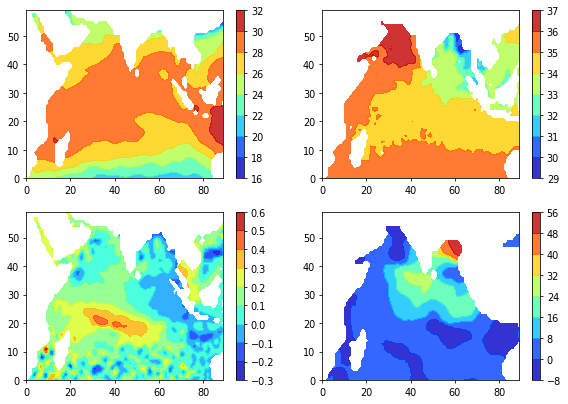

In [14]:
plt.figure(figsize=(10,7),dpi=70)
ax1=plt.subplot(2,2,1)
SSS = ax1.contourf(SST_all[-1,:,:], alpha=0.8, cmap='jet')
cb1 = plt.colorbar(SSS)

ax2=plt.subplot(2,2,2)
SST = ax2.contourf(SSS_all[-1,:,:], alpha=0.8, cmap='jet')
cb2 = plt.colorbar(SST)

ax3=plt.subplot(2,2,3)
SSHA = ax3.contourf(SSHA_all[-1,:,:], alpha=0.8, cmap='jet')
cb3 = plt.colorbar(SSHA)

ax4=plt.subplot(2,2,4)
BLT = ax4.contourf(BLT_all[-1,:,:], alpha=0.8, cmap='jet')
cb4 = plt.colorbar(BLT)

In [19]:
with h5py.File("数据/YINDU_ALL_data.hdf5", 'r') as f:  #‘r’是读取，‘w’是写入
    print(f.keys())
    SSS_all = f.get("SSS_all")[:]
    SST_all = f.get("SST_all")[:]
    PRE_all = f.get("PRE_all")[:]
    SSHA_all = f.get("SSHA_all")[:]
    BLT_all = f.get("BLT_all")[:]
    lat = f.get("lat")[:]
    lon = f.get("lon")[:]

<KeysViewHDF5 ['BLT_all', 'PRE_all', 'SSHA_all', 'SSS_all', 'SST_all', 'lat', 'lon']>


In [4]:
BLT_all.shape

(96, 60, 90)

卫星与Argo数据对比

In [20]:
Argo_0 = xr.open_dataset('数据/argo 05-20 0.nc')

In [21]:
S = np.array(Argo_0['salt'][-12*2:-12,:,60:120,30:120]).reshape(12,5400)
T = np.array(Argo_0['temp'][-12*2:-12,:,60:120,30:120]).reshape(12,5400)

In [22]:
S_c = np.array(SSS_all[-12:,:,:]).reshape(12,5400)
T_c = np.array(SST_all[-12:,:,:]).reshape(12,5400)

In [23]:
for i in range(12):
    weixing_s = np.nanmean(S_c[:,:],axis=1)
    weixing_t = np.nanmean(T_c[:,:],axis=1)
    argo_s = np.nanmean(S[:,:],axis=1)
    argo_t = np.nanmean(T[:,:],axis=1)

In [29]:
S_error_data = pd.DataFrame(np.transpose(S_c[:,:])).dropna()
T_error_data = pd.DataFrame(np.transpose(T_c[:,:])).dropna()

In [90]:
S_E = []
T_E = []
for i in range(12):
    data_test=np.array(S_error_data.iloc[:,i])
    SD_P=np.std(data_test)
    n=len(data_test)
    result = round(SD_P/math.sqrt(n),4)
    S_E.append(result)
    
for i in range(12):
    data_test=np.array(T_error_data.iloc[:,i])
    SD_P=np.std(data_test)
    n=len(data_test)
    result = round(SD_P/math.sqrt(n),4)
    T_E.append(result)

In [ ]:
fig = plt.figure(figsize=(20,5))
font = {'family':'Times New Roman'}
font3 = {'family':'Times New Roman','size':12}
plt.subplot(1,2,1)
plt.plot(weixing_s,label='Satellite SSS',marker='o',c='red')
plt.plot(argo_s,label = 'Argo SSS',marker='o',c='black',linestyle='--')
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
plt.errorbar(x,weixing_s,yerr=S_E,fmt='o',ecolor='r',color='red',elinewidth=2,capsize=4)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15,
          fontproperties='Times New Roman')
plt.yticks(fontsize=15,fontproperties='Times New Roman')
plt.tick_params(labelsize=15)
plt.legend(prop=font3)
plt.grid(linestyle='-.')
plt.ylim(34,36)
plt.ylabel('Salinity(psu)',fontsize=20,fontdict=font)
plt.xlabel('Month',fontsize=20,fontdict=font)
plt.title("(a) Monthly SSS",fontsize=20,fontdict=font)

plt.subplot(1,2,2)
plt.plot(weixing_t,label='Satellite SST',marker='o',c='red')
plt.plot(argo_t,label = 'Argo SST',marker='o',c='black',linestyle='--')
plt.errorbar(x,weixing_t,yerr=T_E,fmt='o',ecolor='r',color='red',elinewidth=2,capsize=4)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15,
          fontproperties='Times New Roman')
plt.yticks(fontsize=15,fontproperties='Times New Roman')
plt.tick_params(labelsize=15)
plt.legend(prop=font3)
plt.grid(linestyle='-.')
plt.ylim(25,29)
plt.ylabel('Temperature(\u2103)',fontsize=20,fontdict=font)
plt.xlabel('Month',fontsize=20,fontdict=font)
plt.title("(b) Monthly SST",fontsize=20,fontdict=font)
plt.savefig('图卫星.png')
plt.show()

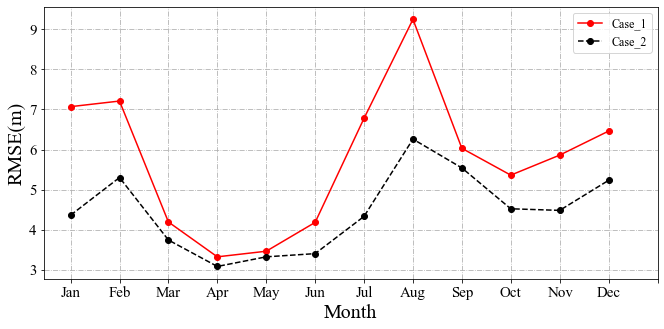

In [10]:
fig = plt.figure(figsize=(11,5))
font = {'family':'Times New Roman'}
font3 = {'family':'Times New Roman','size':12}
plt.subplot(1,1,1)
plt.plot(case_1,label='Case_1',marker='o',c='red')
plt.plot(case_2,label = 'Case_2',marker='o',c='black',linestyle='--')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],fontsize=15,
          fontproperties='Times New Roman')
plt.yticks(fontsize=15,fontproperties='Times New Roman')
plt.tick_params(labelsize=15)
plt.legend(prop=font3)
plt.grid(linestyle='-.')
#plt.ylim(34,36)
plt.ylabel('RMSE(m)',fontsize=20,fontdict=font)
plt.xlabel('Month',fontsize=20,fontdict=font)

plt.savefig('Case1_2_RMSE.png')
plt.show()